In [1]:
import pickle
import sys
import time 
import os
import matplotlib.pyplot as plt
import numpy as np
from pyquaternion import Quaternion
from transforms3d.euler import mat2euler
import mpl_toolkits.mplot3d as a3
import jax
import jax.numpy as jnp
from jax import grad, vmap

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

In [5]:
def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d


print("Current Working Directory:", os.getcwd())

dataset="1"
cfile = "../data/cam/cam" + dataset + ".p"
ifile = "../data/imu/imuRaw" + dataset + ".p"
vfile = "../data/vicon/viconRot" + dataset + ".p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)
toc(ts,"Data import")

Current Working Directory: c:\Users\kvuon\OneDrive\Documents\Personal\UCSD\ECE 276a\ECE276A_PR1\code
Data import took: 3.574540853500366 sec.



In [ ]:
tau=np.array(0)
for i in range(len(imud[0])-1):
    tau = np.append(tau,imud[0][i+1]-imud[0][i]) 

imu_t = imud[0] - imud[0][0] #the time interval is 1/100 seconds

NameError: name 'imu_t' is not defined

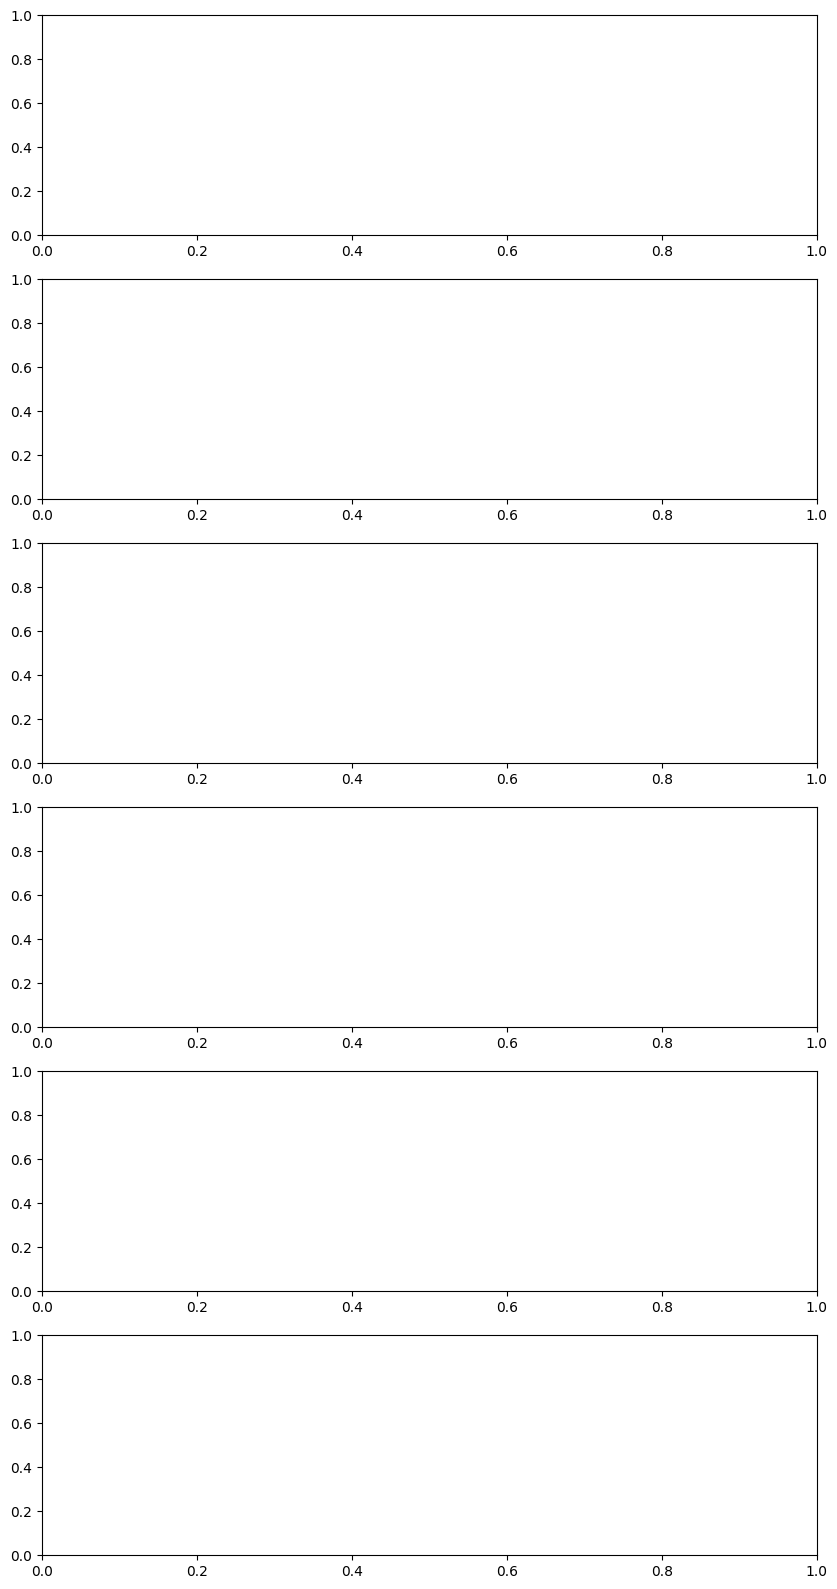

In [2]:
# Plotting ADC IMU Values
fig,axs = plt.subplots(6,1,figsize=(10,20))

for i in range(6):
    axs[i].plot(imu_t,imud[i+1])
    axs[i].ticklabel_format(useOffset=False, style='plain', axis='x')  # Disable offset for each subplot


axs[0].set_title('accel_x')
axs[1].set_title('accel_y')
axs[2].set_title('accel_z')
axs[3].set_title('omega_x')
axs[4].set_title('omega_y')
axs[5].set_title('omega_z')

# Add title to the entire figure
fig.suptitle('ADC IMU Values', fontsize=20)

plt.show()

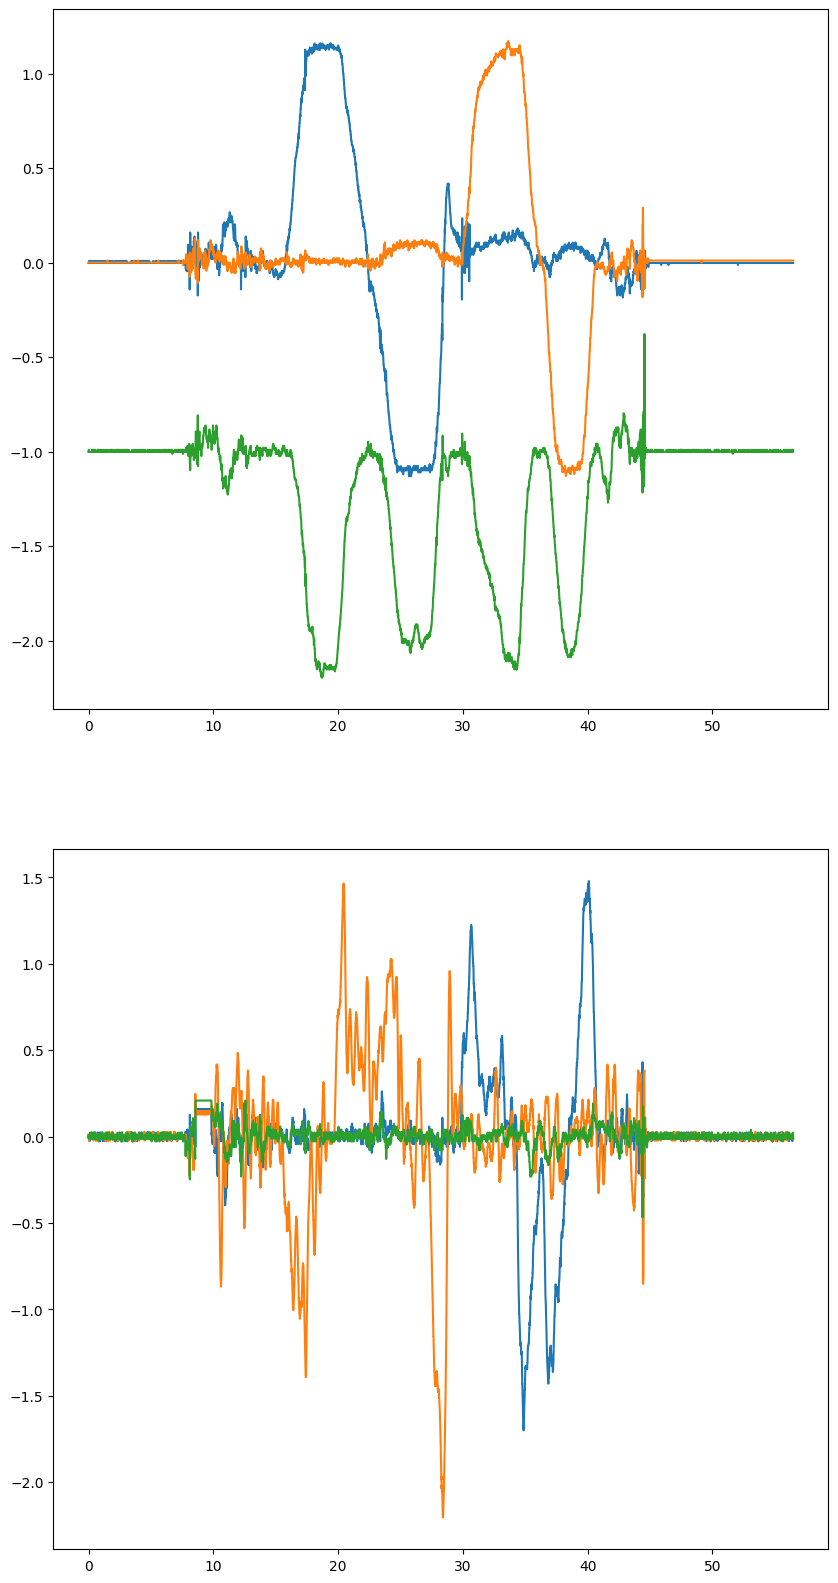

In [8]:
# Obtaining raw values
a_sens = 300 #mV/g
g_sens = 3.33 #mv/(deg/sec)
V_ref = 3300 #mV
adc = 1023

a_conv = (V_ref/adc)/a_sens
pre_a = imud[1:4]

a_savg = np.mean(pre_a[:,:600],axis=1)
# a_savg[2] -= 1
a =  pre_a - a_savg[:,np.newaxis]
a*=a_conv
a[2]-=1


g_conv = (V_ref/adc)*(1/g_sens)*(np.pi/180)
pre_g = imud[4:7]


g_savg = np.mean(pre_g[:,:600],axis=1)
w = pre_g-g_savg[:,np.newaxis]
w *= g_conv


fig,axs = plt.subplots(2,1,figsize=(10,20))
axs[0].plot(imu_t,a[0])
axs[0].plot(imu_t,a[1])
axs[0].plot(imu_t,a[2])
axs[1].plot(imu_t,w[0])
axs[1].plot(imu_t,w[1])
axs[1].plot(imu_t,w[2])




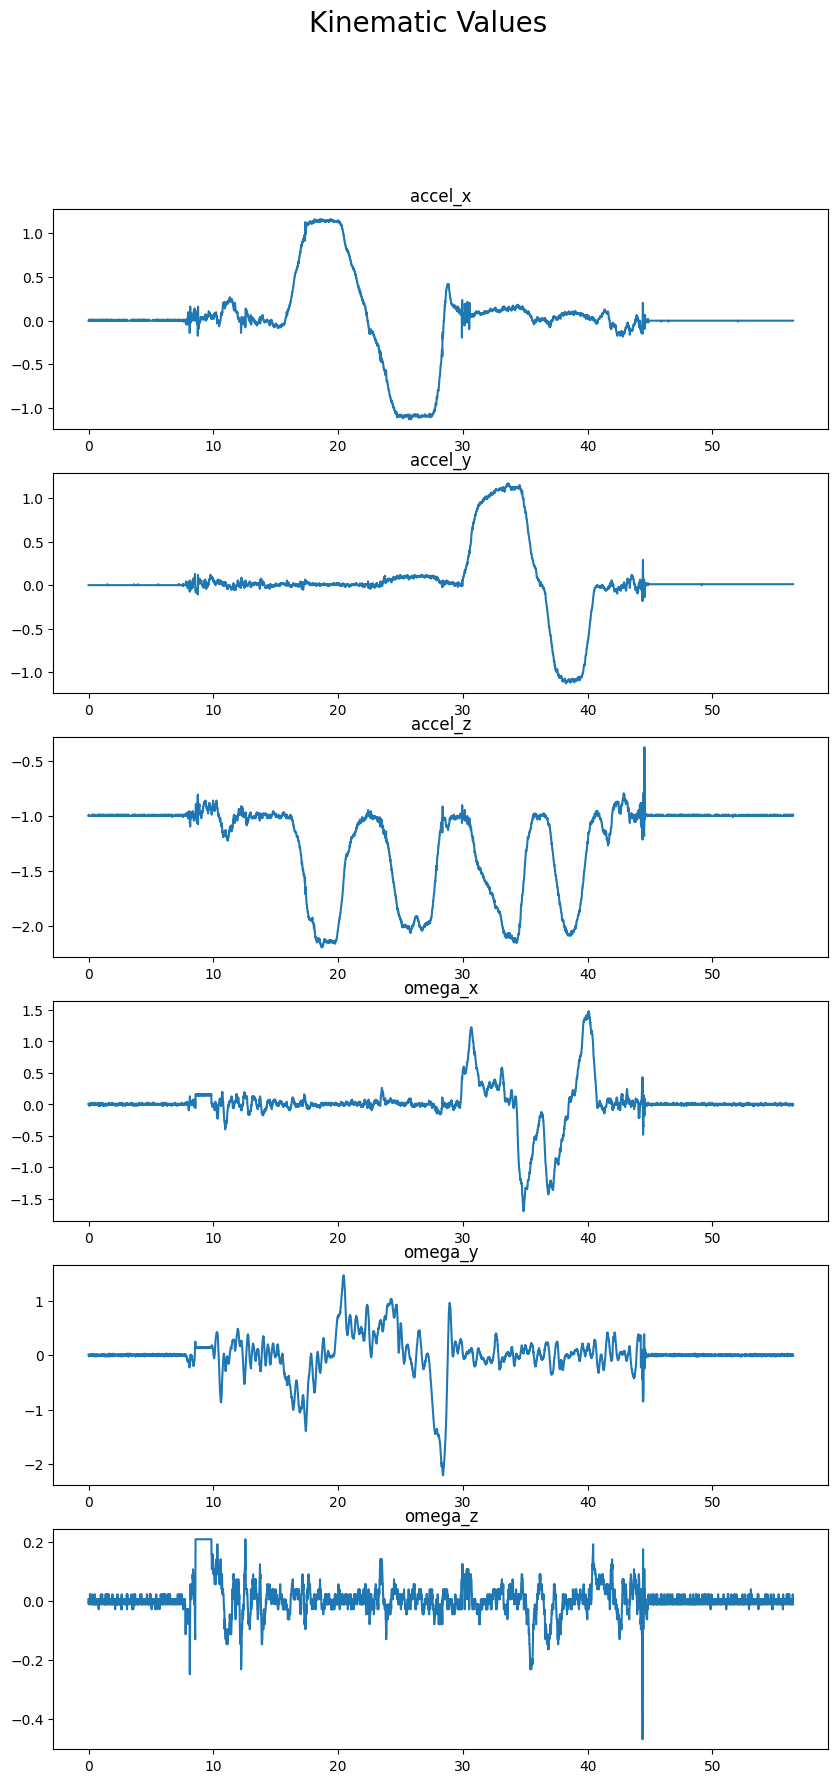

In [9]:
# Plotting ADC IMU Values
fig,axs = plt.subplots(6,1,figsize=(10,20))

for i in range(3):
    axs[i].plot(imu_t,a[i])
    axs[i+3].plot(imu_t,w[i])
    axs[i].ticklabel_format(useOffset=False, style='plain', axis='x')  # Disable offset for each subplot
    axs[i+3].ticklabel_format(useOffset=False, style='plain', axis='x')  # Disable offset for each subplot

axs[0].set_title('accel_x')
axs[1].set_title('accel_y')
axs[2].set_title('accel_z')
axs[3].set_title('omega_x')
axs[4].set_title('omega_y')
axs[5].set_title('omega_z')

# Add title to the entire figure
fig.suptitle('Kinematic Values', fontsize=20)

plt.show()

Euler Angles (degrees):
[[-0.09341679 -0.64458404  0.26116964]
 [-0.06760375 -0.91630894  0.24228668]
 [-0.09856802 -0.68144362  0.27143635]
 [-0.18354375 -0.65876633  0.37160303]
 [-0.14706534 -0.65322761  0.35738373]]


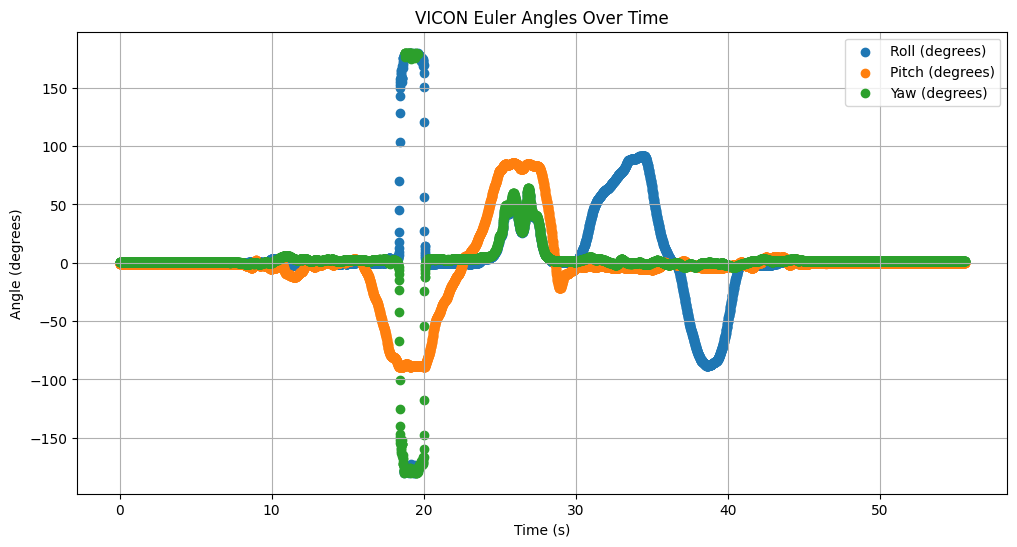

In [10]:
rots = vicd['rots']
vic_t = vicd['ts'][0] - vicd['ts'][0][0]
#get pitch roll and yaw in world frame using matrix operations 
pitch = np.arcsin(-rots[2, 0, :])  # -asin(R[2,0])
roll = np.arctan2(rots[2, 1, :], rots[2, 2, :])  # atan2(R[2,1], R[2,2])
yaw = np.arctan2(rots[1, 0, :], rots[0, 0, :])  # atan2(R[1,0], R[0,0])

# Convert to degrees
roll_deg = np.degrees(roll)
pitch_deg = np.degrees(pitch)
yaw_deg = np.degrees(yaw)

# Combine into a single array
euler_angles_deg = np.stack((roll_deg, pitch_deg, yaw_deg), axis=-1)  # Shape: (N, 3)

# Print the first few results
print("Euler Angles (degrees):")
print(euler_angles_deg[:5])  # Display the first 5 sets of angles

plt.figure(figsize=(12, 6))
plt.scatter(vic_t, euler_angles_deg[:, 0], label="Roll (degrees)")
plt.scatter(vic_t, euler_angles_deg[:, 1], label="Pitch (degrees)")
plt.scatter(vic_t, euler_angles_deg[:, 2], label="Yaw (degrees)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.title("VICON Euler Angles Over Time")
plt.legend()
plt.grid()
plt.show()


In [11]:
def q_exp(q):
    q_s = q[0]  # Scalar part
    q_v = q[1:]  # Vector part

    mag = np.linalg.norm(q_v)

    if mag < 1e-10:  # Handle near-zero case to avoid division by zero
        return np.array([np.exp(q_s), 0, 0, 0])

    cos = np.cos(mag)
    sin = (q_v / mag) * np.sin(mag)

    return np.exp(q_s) * np.concatenate(([cos], sin))

In [12]:
def q_mul(q,p):
    q_s = q[0]
    q_v = q[:3]
    p_s = p[0]
    p_v = p[:3]
    
    # Compute scalar and vector parts of the result
    scalar_part = np.array([q_s * p_s - np.dot(q_v, p_v)])  # Dot product
    vector_part = (q_s * p_v) + (p_s * q_v) + np.cross(q_v, p_v)  # Vector computation

    # Combine scalar and vector parts
    return np.concatenate((scalar_part, vector_part))

In [13]:
def rotplot(R, currentAxes=None):
    """
    Plots the orientation of a 3x3 rotation matrix R.
    """
    lx = 3.0
    ly = 1.5
    lz = 1.0

    x = 0.5 * np.array([
        [+lx, -lx, +lx, -lx, +lx, -lx, +lx, -lx],
        [+ly, +ly, -ly, -ly, +ly, +ly, -ly, -ly],
        [+lz, +lz, +lz, +lz, -lz, -lz, -lz, -lz]
    ])

    xp = np.dot(R, x)
    ifront = np.array([0, 2, 6, 4, 0])
    iback = np.array([1, 3, 7, 5, 1])
    itop = np.array([0, 1, 3, 2, 0])
    ibottom = np.array([4, 5, 7, 6, 4])

    if currentAxes:
        ax = currentAxes
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')  # Use add_subplot instead of gca

    ax.plot(xp[0, itop], xp[1, itop], xp[2, itop], 'k-')
    ax.plot(xp[0, ibottom], xp[1, ibottom], xp[2, ibottom], 'k-')

    rectangleFront = a3.Poly3DCollection([list(zip(xp[0, ifront], xp[1, ifront], xp[2, ifront]))])
    rectangleFront.set_facecolor('Blue')
    ax.add_collection(rectangleFront)

    rectangleBack = a3.Poly3DCollection([list(zip(xp[0, iback], xp[1, iback], xp[2, iback]))])
    rectangleBack.set_facecolor('Red')
    ax.add_collection(rectangleBack)

    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)

    return ax


In [14]:
def plot_euler_angles(rotation_matrices, imu_t):
    """
    Plots yaw, pitch, and roll over time using mat2euler from transformations3d.

    Args:
        rotation_matrices (np.ndarray): Array of shape (n, 3, 3) containing rotation matrices.
        imu_t (np.ndarray): Array of time steps corresponding to the rotation matrices.
    """
    # Initialize arrays to store Euler angles
    yaw = []
    pitch = []
    roll = []

    # Convert each rotation matrix to Euler angles using mat2euler
    for R in rotation_matrices:
        angles = mat2euler(R, axes='szyx')  # 'szyx' -> Intrinsic yaw-pitch-roll
        yaw.append(np.degrees(angles[0]))   # Yaw (around Z-axis)
        pitch.append(np.degrees(angles[1])) # Pitch (around Y-axis)
        roll.append(np.degrees(angles[2]))  # Roll (around X-axis)

    # Convert to NumPy arrays
    yaw = np.array(yaw)
    pitch = np.array(pitch)
    roll = np.array(roll)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(imu_t, yaw, label="Yaw (ψ)")
    plt.plot(imu_t, pitch, label="Pitch (θ)")
    plt.plot(imu_t, roll, label="Roll (φ)")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Yaw, Pitch, and Roll over Time")
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
#Checking whether IMU calibration is correct
q0 = Quaternion(1,0,0,0)
n = len(imu_t)

q = np.empty(n,dtype=object)
R = np.empty(n,dtype=object)
q[0] = q0
R[0] = q0.rotation_matrix

#RESHAPING OMEGA AND ACCEL MATRICES
w_vec = w.T
a_vec = a.T

for t in range(1,n):
    tau_t = imu_t[t]-imu_t[t-1]
    p = Quaternion(np.concatenate(([0],tau_t * w_vec[t-1]/2)))
    p = Quaternion.exp(p)
    q[t] = q[t-1]*p
    q[t] = q[t].unit
    R[t] = q[t].rotation_matrix


q_w = np.array([q[i].w for i in range(len(q))])
q_x = np.array([q[i].x for i in range(len(q))])
q_y = np.array([q[i].y for i in range(len(q))])
q_z = np.array([q[i].z for i in range(len(q))])



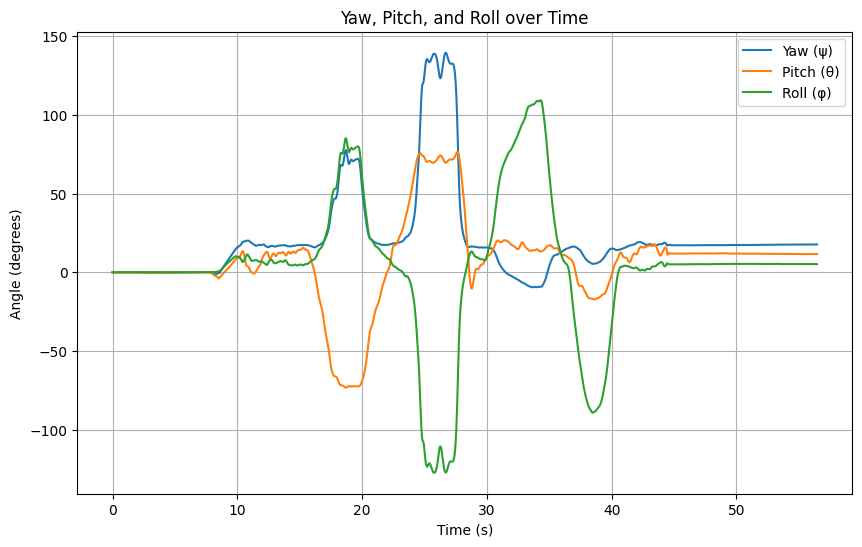

In [16]:
plot_euler_angles(R,imu_t)

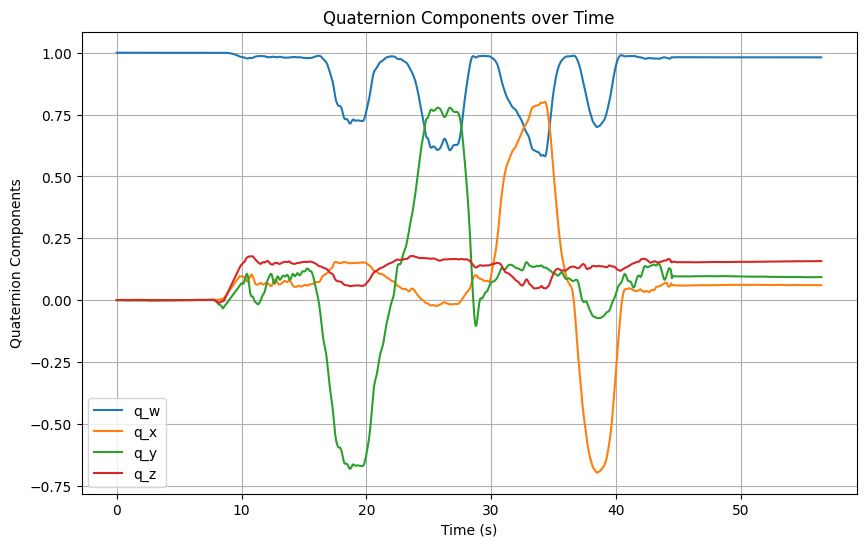

In [17]:
# Plot quaternion components
plt.figure(figsize=(10, 6))
plt.plot(imu_t, q_w, label="q_w")
plt.plot(imu_t, q_x, label="q_x")
plt.plot(imu_t, q_y, label="q_y")
plt.plot(imu_t, q_z, label="q_z")

plt.xlabel("Time (s)")
plt.ylabel("Quaternion Components")
plt.title("Quaternion Components over Time")
plt.legend()
plt.grid()
plt.show()

In [18]:
# Quaternion operations (as defined earlier)
def quaternion_conjugate(q):
    w, x, y, z = q
    return jnp.array([w, -x, -y, -z])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return jnp.array([
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2,
    ])

def quaternion_log(q):
    w, x, y, z = q
    v = jnp.array([x, y, z])
    norm_v = jnp.linalg.norm(v)
    theta = jnp.arctan2(norm_v, w)
    return jnp.hstack([0, v * theta / norm_v]) if norm_v > 1e-8 else jnp.zeros(4)

def f(q, omega, tau):
    omega_quat = jnp.hstack([0, omega * tau / 2])
    delta_q = quaternion_multiply(q, omega_quat)
    return delta_q / jnp.linalg.norm(delta_q)

def h(q):
    gravity = jnp.array([0, 0, 0, -9.81])
    return quaternion_multiply(
        quaternion_multiply(quaternion_conjugate(q), gravity), q
    )


In [19]:
q = jnp.zeros((n,4))

NameError: name 'jnp' is not defined

In [ ]:

# Vectorized Cost Function
def cost_function(q_sequence, omega_sequence, a_sequence, tau):
    q_t = q_sequence[:-1]  # q_t from 0 to T-1
    q_t1 = q_sequence[1:]  # q_t+1 from 1 to T
    propagated_q = vmap(f, in_axes=(0, 0, None))(q_t, omega_sequence, tau)
    relative_rotation = vmap(quaternion_multiply)(
        vmap(quaternion_conjugate)(q_t1), propagated_q
    )
    motion_cost = jnp.sum(
        jnp.linalg.norm(2 * vmap(quaternion_log)(relative_rotation), axis=1) ** 2
    )
    transformed_accel = vmap(h)(q_sequence[1:])
    observation_cost = jnp.sum(
        jnp.linalg.norm(jnp.hstack([jnp.zeros((a_sequence.shape[0], 1)), a_sequence]) - transformed_accel, axis=1) ** 2
    )
    return 0.5 * motion_cost + 0.5 * observation_cost, motion_cost, observation_cost

# Example Setup
T = 10  # Number of time steps
tau = 0.1  # Time step
q_sequence = jnp.zeros((T + 1, 4))  # Placeholder for quaternion sequence

# Simulate angular velocities (omega_sequence)
omega_sequence = jnp.array([[0.1, 0.2, 0.3]] * T)  # Simulated angular velocities

# Initialize quaternion trajectory using the motion model
q_sequence = jnp.zeros((T + 1, 4))
q_sequence = q_sequence.at[0].set(jnp.array([1.0, 0.0, 0.0, 0.0]))  # Initial quaternion
for t in range(T):
    q_sequence = q_sequence.at[t + 1].set(f(q_sequence[t], omega_sequence[t], tau))

# Simulate acceleration data (a_sequence)
a_sequence = jnp.array([[0.0, 0.0, -9.81]] * T)  # Gravity with no noise

# Verify Initialization
total_cost, motion_cost, observation_cost = cost_function(q_sequence, omega_sequence, a_sequence, tau)
print(f"Initial Total Cost: {total_cost:.6f}")
print(f"Initial Motion Cost: {motion_cost:.6f} (Should be 0)")
print(f"Initial Observation Cost: {observation_cost:.6f}")
